In [1]:
import pandas as pd
import matplotlib.pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# complaints data imported November, 2016
complaints = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7,11,12,13,14,20,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
complaints = complaints.drop(['Cross Street 1', 'Cross Street 2', 'City', 'Agency Name', 'Street Name', 'Due Date', 'Borough', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Location Type', 'Intersection Street 1', 'Intersection Street 2', 'Landmark', 'Facility Type', 'School Not Found', 'School or Citywide Complaint', 'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction', 'Ferry Terminal Name', 'School Name', 'School Number', 'School Region', 'School Code', 'School Phone Number', 'School Address', 'School City', 'School State', 'School Zip', 'Park Facility Name', 'Park Borough'], axis=1)

In [4]:
#create a date index to select data from 2015 only
dates = [elem for elem in complaints['Created Date']]
formatteddates = []
for i in range(0,len(dates)):
    formatteddates.append(dates[i][:-3])

In [5]:
complaints['Date Index'] = formatteddates

In [6]:
complaints['Date Index'] = pd.to_datetime(complaints['Date Index'], format = "%m/%d/%Y %H:%M:%S")

In [7]:
complaints['Incident Zip'] = complaints['Incident Zip'].fillna(0.0).astype(int)

In [8]:
complaints = complaints[complaints['Incident Zip'] > 0]

In [9]:
complaints = complaints.set_index('Date Index')

In [10]:
#select complaints for 2015 only
complaints = complaints.loc['2015-01-01':'2016-01-01']

In [11]:
complaints = pd.DataFrame(complaints['Unique Key'].groupby([complaints['Incident Zip']]).count())

In [12]:
complaints = complaints.rename(columns={'Unique Key': 'Count of Complaints'})

In [13]:
complaints = complaints.reset_index()

In [14]:
complaints.head()

,Incident Zip,Count of Complaints
0,10001,611
1,10002,789
2,10003,822
3,10004,52
4,10005,41


In [15]:
print(len(complaints))

194


In [16]:
# 2015 population data imported December, 2016
zcpop = pd.read_csv('ACS_15_5YR_B01003/ACS_15_5YR_B01003_with_ann.csv')

In [17]:
zcpop = zcpop.drop(['GEO.id', 'GEO.display-label', 'HD02_VD01'], axis=1)

In [18]:
zcpop.rename(columns={'HD01_VD01':'2015 Population Estimate'}, inplace=True)

In [19]:
zcpop = zcpop.ix[1:]

In [20]:
zcpop['GEO.id2'] = zcpop['GEO.id2'].astype(int)

In [21]:
zcpop.head()

,GEO.id2,2015 Population Estimate
1,6390,339
2,10001,23537
3,10002,80736
4,10003,57112
5,10004,3221


In [22]:
# zip code shape file imported December, 2016
shp = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')

In [23]:
shp = shp[['ZIPCODE', 'geometry']]

In [24]:
shp.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [25]:
shp['ZIPCODE'] = shp['ZIPCODE'].astype(int)

In [26]:
# violations

In [27]:
popshp = pd.merge(shp, zcpop, left_on='ZIPCODE', right_on='GEO.id2', how='left')

In [28]:
popshp.sort_values('ZIPCODE').head()

,ZIPCODE,geometry,GEO.id2,2015 Population Estimate
54,83,"POLYGON ((998309.7254775614 229616.6812362969,...",NaN,NaN
82,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",10001.0,23537
92,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",10002.0,80736
90,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",10003.0,57112
113,10004,"POLYGON ((977542.4500830621 188447.2783390433,...",10004.0,3221


In [29]:
print(len(popshp))

263


In [30]:
complaintshp = pd.merge(complaints, popshp, left_on='Incident Zip', right_on='ZIPCODE', how='right')

In [31]:
complaintshp = complaintshp.drop(['Incident Zip', 'GEO.id2'], axis=1)

In [32]:
complaintshp.head()

,Count of Complaints,ZIPCODE,geometry,2015 Population Estimate
0,611.0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",23537
1,789.0,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",80736
2,822.0,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",57112
3,52.0,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",3221
4,52.0,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",3221


In [33]:
complaintshp['2015 Population Estimate'] = complaintshp['2015 Population Estimate'].fillna(0.0).astype(int)

In [34]:
complaintshp['Complaints per Person'] = complaintshp['Count of Complaints'].divide(complaintshp['2015 Population Estimate'])

In [35]:
complaintshp = complaintshp[complaintshp['2015 Population Estimate'] > 0]

In [36]:
complaintshp = complaintshp.dropna()

In [37]:
complaintshp = complaintshp.set_geometry('geometry')

In [38]:
# merge violations
violations = pd.read_csv('bblvios.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
violations = violations.drop(['ECB_NUMBER', 'Unnamed: 0'], axis=1)

In [40]:
# create date index to select violations from 2015 only
dates = [elem for elem in violations['ISSUE_DATE']]

In [41]:
t = dates[:500000]
z = []
for i in range(0,len(t)):
    z.append(pd.to_datetime(str(t[i]), format='%Y%m%d', errors='coerce'))

In [42]:
t = dates[500000:1000000]
y = []
for i in range(0,len(t)):
    y.append(pd.to_datetime(str(t[i]), format='%Y%m%d', errors='coerce'))

In [43]:
t = dates[1000000:1500000]
x = []
for i in range(0,len(t)):
    x.append(pd.to_datetime(str(t[i]), format='%Y%m%d', errors='coerce'))

In [44]:
t = dates[1500000:1822219]
w = []
for i in range(0,len(t)):
    w.append(pd.to_datetime(str(t[i]), format='%Y%m%d', errors='coerce'))

In [45]:
a = z + y + x + w

In [46]:
violations['Date Index'] = a

In [47]:
violations.index = violations['Date Index']

In [48]:
violations = violations.loc['2015-01-01':'2016-01-01']

In [49]:
violations = violations.drop(['Date Index'], axis=1)

In [50]:
violations = violations.reset_index()

In [51]:
violations['zipcode'] = violations['zipcode'].astype(int)

In [52]:
violations = pd.DataFrame(violations['ISN_DOB_BIS_VIOL'].groupby([violations['zipcode']]).count())

In [53]:
violations = violations.reset_index()
violations = violations.rename(columns={'ISN_DOB_BIS_VIOL': 'Count of Violations'})

In [54]:
compvioshp = pd.merge(complaintshp, violations, left_on='ZIPCODE', right_on='zipcode')

In [55]:
compvioshp['Violations per Person'] = compvioshp['Count of Violations'].divide(compvioshp['2015 Population Estimate'])

In [56]:
compvioshp.head()

,Count of Complaints,ZIPCODE,geometry,2015 Population Estimate,Complaints per Person,zipcode,Count of Violations,Violations per Person
0,611.0,10001,"POLYGON ((981958.6472873986 213464.4530421346,...",23537,0.025959,10001,906,0.038493
1,789.0,10002,"POLYGON ((991339.8703228086 207576.7837151289,...",80736,0.009773,10002,570,0.007060
2,822.0,10003,"POLYGON ((989830.469142139 207048.1263078749, ...",57112,0.014393,10003,896,0.015688
3,52.0,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",3221,0.016144,10004,160,0.049674
4,52.0,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",3221,0.016144,10004,160,0.049674


In [57]:
compvioshp['Violations per Complaints'] = compvioshp['Count of Violations'].divide(compvioshp['Count of Complaints'])

In [58]:
compvioshp.isnull().sum()

Count of Complaints          0
ZIPCODE                      0
geometry                     0
2015 Population Estimate     0
Complaints per Person        0
zipcode                      0
Count of Violations          0
Violations per Person        0
Violations per Complaints    0
dtype: int64

In [75]:
plotter = compvioshp.sort_values(by='Violations per Complaints', ascending=0).head(10)

In [76]:
plotter

,Count of Complaints,ZIPCODE,geometry,2015 Population Estimate,Complaints per Person,zipcode,Count of Violations,Violations per Person,Violations per Complaints
41,11.0,10044,"POLYGON ((995262.8605083078 213107.8290834725,...",11783,0.000934,10044,56,0.004753,5.090909
48,7.0,10282,"POLYGON ((979667.1121723056 201103.8596531302,...",5730,0.001222,10282,33,0.005759,4.714286
7,41.0,10005,"POLYGON ((982595.6794779003 195880.7536295503,...",8131,0.005042,10005,190,0.023367,4.634146
3,52.0,10004,"POLYGON ((981197.408652395 196571.0816452205, ...",3221,0.016144,10004,160,0.049674,3.076923
4,52.0,10004,"POLYGON ((972696.8446168154 193014.5477478057,...",3221,0.016144,10004,160,0.049674,3.076923
5,52.0,10004,"POLYGON ((977542.4500830621 188447.2783390433,...",3221,0.016144,10004,160,0.049674,3.076923
6,52.0,10004,"POLYGON ((971218.3702115566 190710.8587856293,...",3221,0.016144,10004,160,0.049674,3.076923
17,201.0,10017,"POLYGON ((990440.5063079 215404.9508015513, 99...",16472,0.012203,10017,593,0.036000,2.950249
20,290.0,10021,"POLYGON ((998204.3503602296 218909.3384778053,...",43573,0.006655,10021,566,0.012990,1.951724
18,321.0,10018,"POLYGON ((983778.6019808054 216668.1490625441,...",9168,0.035013,10018,588,0.064136,1.831776


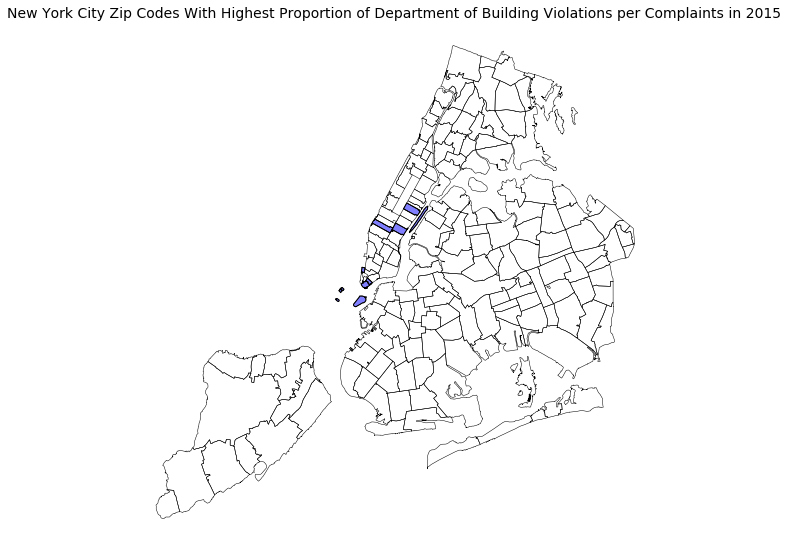

In [77]:
ax = complaintshp.plot(alpha=0, figsize=(10,10), linewidth=.5)
plotter.plot(ax=ax, color='b')
ax.set_axis_off()
plt.title('New York City Zip Codes With Highest Proportion of Department of Building Violations per Complaints in 2015', fontsize=14)

In [81]:
plotter = compvioshp.sort_values(by='Violations per Complaints', ascending=0).tail(10)

In [82]:
plotter

,Count of Complaints,ZIPCODE,geometry,2015 Population Estimate,Complaints per Person,zipcode,Count of Violations,Violations per Person,Violations per Complaints
146,342.0,11364,"POLYGON ((1045257.876659811 213288.8638263792,...",34949,0.009786,11364,53,0.001516,0.154971
170,1281.0,11419,"POLYGON ((1029301.697942317 191200.7022941262,...",49306,0.025981,11419,196,0.003975,0.153005
173,334.0,11422,"POLYGON ((1060642.852451473 188482.9035958797,...",33245,0.010047,11422,51,0.001534,0.152695
186,302.0,11692,"POLYGON ((1041797.849787235 157921.3987741321,...",18955,0.015932,11692,46,0.002427,0.152318
171,973.0,11420,"POLYGON ((1037510.873124972 189653.9419362098,...",50820,0.019146,11420,135,0.002656,0.138746
89,44.0,11001,"POLYGON ((1067113.206636727 208617.5427884609,...",27551,0.001597,11001,6,0.000218,0.136364
165,479.0,11414,"POLYGON ((1025670.681254223 184011.3803867102,...",28700,0.016690,11414,60,0.002091,0.125261
59,415.0,10312,"POLYGON ((928850.4533071518 143511.4033159614,...",62032,0.006690,10312,47,0.000758,0.113253
192,136.0,11697,"POLYGON ((1016691.779920727 146366.408760801, ...",4006,0.033949,11697,10,0.002496,0.073529
175,238.0,11426,"POLYGON ((1063134.367809638 208633.765525043, ...",19842,0.011995,11426,17,0.000857,0.071429


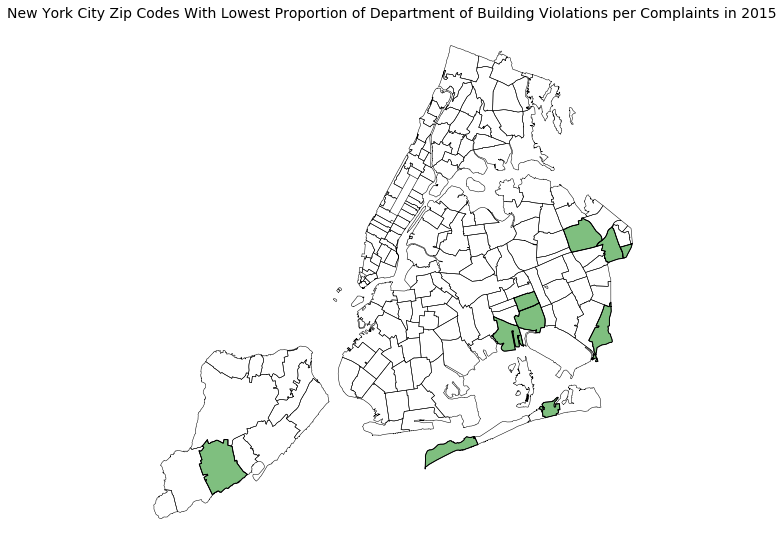

In [83]:
ax = complaintshp.plot(alpha=0, figsize=(10,10), linewidth=.5)
plotter.plot(ax=ax, color='g')
ax.set_axis_off()
plt.title('New York City Zip Codes With Lowest Proportion of Department of Building Violations per Complaints in 2015', fontsize=14)